Current time: 04:30


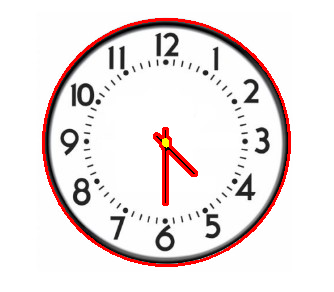

In [140]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# Load the input image
def load_image(image_path):
    return cv2.imread(image_path)

# Convert the image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (15, 15), 0)

# Detect the circular boundary of the clock in the image
def detect_clock_boundary(image, min_distance=20, param1=50, param2=30):
    gray = convert_to_grayscale(image)
    gray_blurred = apply_gaussian_blur(gray)
    circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=min_distance,
                           param1=param1, param2=param2, minRadius=0, maxRadius=0)
    return circles

# Find the clock hands within the circular region of interest
def find_clock_hands(image, center, radius, width_range_hour=(70, 100), width_range_minute=(100, 200)):
    roi_x, roi_y = center
    roi_radius = int(radius * 0.7)
    roi_x1 = roi_x - roi_radius
    roi_x2 = roi_x + roi_radius
    roi_y1 = roi_y - roi_radius
    roi_y2 = roi_y + roi_radius
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2]

    # Detect edges in the region of interest
    roi_edges = cv2.Canny(roi, 30, 150)

    # Find contours in the edge-detected image
    roi_contours, _ = cv2.findContours(roi_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    hour_hand_contour, minute_hand_contour = None, None

    # Identify the clock hands based on their length and orientation
    for contour in roi_contours:
        if cv2.contourArea(contour) > 10:
            (x, y), (width, height), angle = cv2.minAreaRect(contour)
            if width > height:
                angle += 90
            if width_range_hour[0] < width < width_range_hour[1]:
                hour_hand_contour = contour
                hour_hand_contour[:, :, 0] += roi_x1
                hour_hand_contour[:, :, 1] += roi_y1
            elif width_range_minute[0] < width < width_range_minute[1]:
                minute_hand_contour = contour
                minute_hand_contour[:, :, 0] += roi_x1
                minute_hand_contour[:, :, 1] += roi_y1

    return hour_hand_contour, minute_hand_contour

# Calculate the angles of clock hands with respect to the center
def calculate_angles(hand_tip, center):
    dx = hand_tip[0] - center[0]
    dy = hand_tip[1] - center[1]
    angle = math.degrees(math.atan2(dy, dx))
    return angle

# Calculate the current time based on the angles of clock hands
def calculate_time(hour_angle, minute_angle, angle_12, angle_3):
    hour = (hour_angle - angle_12) / (angle_3 - angle_12) * 3
    minute = (minute_angle - angle_12) / (angle_3 - angle_12) * 15

    # Ensure the angles are within the range [0, 360)
    if hour < 0:
        hour += 12
    if minute < 0:
        minute += 60

    return int(hour), int(minute

# Draw outlines of the circular clock and clock hands
def draw_outlines(image, center, hour_hand_contour, minute_hand_contour):
    cv2.circle(image, center, radius, (0, 0, 255), 2)  # Circular boundary
    cv2.circle(image, center, 5, (0, 255, 255), -1)  # Center point

    if minute_hand_contour is not None:
        cv2.drawContours(image, [minute_hand_contour], -1, (0, 255, 0), 2)

    if hour_hand_contour is not None:
        cv2.drawContours(image, [hour_hand_contour], -1, (0, 0, 255), 2)

# Main function to execute clock detection and time calculation
def main():
    clock_image = load_image("/content/drive/MyDrive/pics/clock.jpg")
    circles = detect_clock_boundary(clock_image)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        max_circle = circles[0, 0]
        center = (max_circle[0], max_circle[1])
        radius = max_circle[2]

    hour_hand_contour, minute_hand_contour = find_clock_hands(clock_image, center, radius)

    angle_12 = calculate_angles(position_12, center)
    angle_3 = calculate_angles(position_3, center)
    angle_6 = calculate_angles(position_6, center)
    angle_9 = calculate_angles(position_9, center)

    hour_hand_angle = calculate_angles(hour_tip_large, center)
    minute_hand_angle = calculate_angles(minute_tip_large, center)

    current_hour, current_minute = calculate_time(hour_hand_angle, minute_hand_angle, angle_12, angle_3)

    draw_outlines(clock_image, center, hour_hand_contour, minute_hand_contour)

    print(f"Current time: {current_hour:02d}:{current_minute:02d}")

    cv2_imshow(clock_image)

if __name__ == "__main__":
    main()


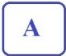

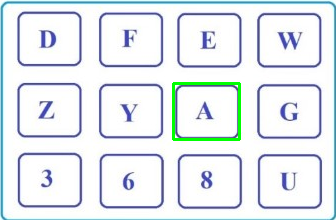

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image with both upper and lower sections
def load_image(image_path):
    return cv2.imread(image_path)

# Extract a character from the upper section based on coordinates
def extract_character(upper_section, char_x_start, char_x_end, char_y_start, char_y_end):
    return upper_section[char_y_start:char_y_end, char_x_start:char_x_end]

# Extract the lower portion based on coordinates
def extract_lower_portion(image, lower_x_start, lower_x_end, lower_y_start, lower_y_end):
    return image[lower_y_start:lower_y_end, lower_x_start:lower_x_end]

# Perform template matching between a template (character) and an image (lower portion)
def template_matching(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

# Find matching regions based on a threshold
def find_matching_regions(result, threshold):
    return np.where(result >= threshold)

# Draw bounding boxes around matching regions
def draw_bounding_boxes(image, locations, template_width, template_height):
    image_with_bbox = image.copy()
    for loc in zip(*locations[::-1]):
        x, y = loc
        w, h = template_width, template_height
        cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image_with_bbox

def main():
    # Load the image with both upper and lower sections
    image = load_image('/content/drive/MyDrive/pics/box.jpg')

    # Define the coordinates for the first character in the upper section
    char_x_start, char_x_end, char_y_start, char_y_end = 132, 198, 14, 70

    # Extract the character from the upper section based on the coordinates
    character = extract_character(image, char_x_start, char_x_end, char_y_start, char_y_end)

    # Define the coordinates for the lower portion
    lower_x_start, lower_x_end, lower_y_start, lower_y_end = 3, 339, 92, 312

    # Extract the lower portion based on the coordinates
    lower_portion = extract_lower_portion(image, lower_x_start, lower_x_end, lower_y_start, lower_y_end)

    # Create a copy of the lower portion for drawing the bounding box
    lower_with_bbox = lower_portion.copy()

    # Perform template matching between the character and the lower portion
    result = template_matching(lower_portion, character)

    # Define a threshold for matching
    threshold = 0.95

    # Find locations where the result is above the threshold
    locations = find_matching_regions(result, threshold)

    # Draw bounding boxes around matching regions
    image_with_bboxes = draw_bounding_boxes(lower_with_bbox, locations, character.shape[1], character.shape[0)

    # Display the extracted character from the upper portion
    cv2_imshow(character)

    # Display the lower portion with matching regions outlined
    cv2_imshow(image_with_bboxes)

if __name__ == "__main__":
    main()


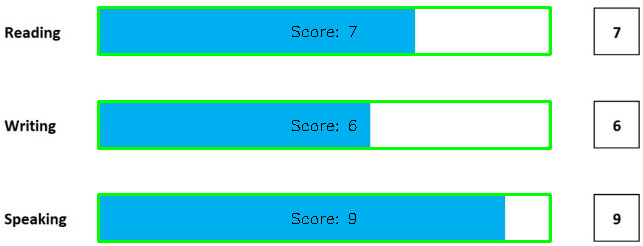

In [136]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math

# Function to load an image
def load_image(image_path):
    return cv2.imread(image_path)

# Function to calculate the score for a given test bar
def calculate_score(test_roi, x1, x2, y1, y2):
    # Create a binary mask for white color (255, 255, 255)
    white_mask = cv2.inRange(test_roi, (255, 255, 255), (255, 255, 255))

    # Count the number of white pixels
    num_white_pixels = np.count_nonzero(white_mask)

    # Calculate the total number of pixels (excluding black)
    total_pixels = np.prod(test_roi.shape[:2])
    black_mask = cv2.inRange(test_roi, (0, 0, 0), (0, 0, 0))
    num_black_pixels = np.count_nonzero(black_mask)
    num_non_black_pixels = total_pixels - num_black_pixels

    # Scale the white pixel count to a 0-10 range
    scale = 10
    scaled_white_pixels = (num_white_pixels / num_non_black_pixels) * scale

    # Round off the scaled value to the next whole number
    rounded_scaled_white_pixels = math.ceil(scaled_white_pixels)

    # Calculate the score by subtracting from 10
    score = 10 - rounded_scaled_white_pixels
    return score

# Function to add outlines around each of the 10 squares
def add_square_outlines(image, x1, x2, y1, y2):
    for i in range(10):
        square_x1 = x1 + i * (x2 - x1) // 10
        square_x2 = x1 + (i + 1) * (x2 - x1) // 10
        cv2.rectangle(image, (square_x1, y1), (square_x2, y2), (0, 255, 0), 2)

# Function to add scores to the image inside the respective bars
def add_scores_to_image(image, x1, x2, y1, y2, score):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 0)
    font_thickness = 1
    text = f'Score: {score}'
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = (x1 + x2 - text_size[0]) // 2
    text_y = (y1 + y2 + text_size[1]) // 2
    cv2.putText(image, text, (text_x, text_y), font, font_scale, font_color, font_thickness)

# Function to process the image, calculate scores, and add outlines and scores
def process_image(image):
    if image is None:
        print("Image not found. Please provide the correct path to the image.")
        return

    # Define ROIs for each test bar
    rois = {
        'reading': (98, 7, 550, 54),
        'writing': (98, 101, 550, 148),
        'speaking': (98, 194, 550, 241),
    }

    # Iterate over the ROIs and calculate scores
    for test, (x1, y1, x2, y2) in rois.items():
        # Add outlines around each of the 10 squares
        add_square_outlines(image, x1, x2, y1, y2)

        # Add outlines around the bar
        test_roi = image[y1:y2, x1:x2]
        score = calculate_score(test_roi, x1, x2, y1, y2)

        # Add scores to the image inside the respective bars
        add_scores_to_image(image, x1, x2, y1, y2, score)

    # Display the image with scores and outlines using cv2_imshow
    cv2_imshow(image)

    # To save the image with scores and outlines
    cv2.imwrite('image_with_scores_and_outlines.jpg', image)

def main():
    image_path = '/content/drive/MyDrive/pics/blue_bars.jpg'
    image = load_image(image_path)
    process_image(image)

if __name__ == "__main__":
    main()
